## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [46]:
# Read the data in ab_data.csv and view the first few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [47]:
# Review the shape of the dataframe
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [48]:
# Determine the number of unique values for the user_id row
unique_users = len(df.user_id.unique())
unique_users

290584

d. The proportion of users converted.

In [49]:
# Calculate the number of unique users who converted and proportion of all unique users
converted = len(df.query('converted == 1').user_id.unique())
proportion = converted / unique_users
converted, proportion

(35173, 0.12104245244060237)

e. The number of times the `new_page` and `treatment` don't line up.

In [50]:
# Query to determine how many rows have treatment is not new_page or new_page is not treatment
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [51]:
# Check the dataframe info to see if any rows have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Result:** 
Since every column has the same number of values as the total number of entries, 294478, there are no null values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [52]:
# Create a new dataset by selecting only those rows where new_page aligns with treatment and check the shape
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.shape

(290585, 5)

In [53]:
# Double Check all of the misaligned rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [54]:
# Determine the number of unique values for the user_id row
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [55]:
# Determine which user_id is duplicated by selecting the row as series and then selecting the id from the series
dup = df2[df2.duplicated(['user_id']) == True]['user_id']
dup_id = dup.iloc[0]
dup_id

773192

c. What is the row information for the repeat **user_id**? 

In [56]:
# Select the rows for the duplicated ID found above, 773192
dup_rows = df2[df2['user_id'] == dup_id]
dup_rows

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [57]:
# Identify the 2nd row (2893) for the user_id of 773192 and then drop the row from df2 and verify the shape has 1 fewer row
# row_2 = dup_rows.index.values[1] # the next few lines worked, but the method below is more elegant and quicker
# print(row_2)
# df2 = df2.drop([row_2, row_2])
df2 = df2.drop_duplicates('user_id', keep='first', inplace=False)
rows = df2.shape[0]
rows

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [58]:
# Determine how many rows were converted and calculate the probability 
converted = df2.query('converted == 1').shape[0]
p_converted = converted/rows
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [59]:
# Select the control group and then those who converted and determine the probability
df2_control = df2.query('group == "control"')
control_converted = df2_control.query('converted == 1')
p_control_converted = control_converted.shape[0]/df2_control.shape[0]
p_control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [60]:
# Select the treatment group and then those who converted and determine the probability
df2_treatment = df2.query('group == "treatment"')
treatment_converted = df2_treatment.query('converted == 1')
p_treatment_converted = treatment_converted.shape[0]/df2_treatment.shape[0]
p_treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [61]:
df2_newpage = df2.query('landing_page == "new_page"')
df2_newpage.shape[0]/rows

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Results:**
Because the probability of conversion is nearly the same for those in the control group (.1203) as those who were in the treatment group (.1188), there is not sufficient evidence that the new page leads to more conversions. Also, the last calculation shows there is a roughly 50% probability that the individual received the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

$$ \alpha = 0.05$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [62]:
# Based on the assumption above, p_new should be set to the same as the converted rate calculated in 4a
p_new = p_converted
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [63]:
# Based on the assumption above, p_old should be set to the same as the converted rate calculated in 4a
p_old = p_converted
p_old

0.11959708724499628

c. What is $n_{new}$?

In [64]:
# The new sample size is equal to the number of times individuals reached the new page
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [65]:
# The old sample size is equal to the number of times individuals reached the old page
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [66]:
# Use np.random.binomial to simulate n_new transactions of 0 or 1 with rate of p_new
new_page_converted = np.random.binomial(2, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [67]:
# Use np.random.binomial to simulate n_old transactions of 0 or 1 with rate of p_old
old_page_converted = np.random.binomial(2, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [68]:
# Calculate the difference between the new page and the old page conversion
# Since the simulated transactions are an array of 1's and 0's, the mean of the array is the same as the probability
new_page_converted.mean() - old_page_converted.mean()

-0.0008299747557492243

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [78]:
p_diffs = []

# The rows below worked, but there is a faster, more elegant way below
# for _ in range(10000):
#    new_page_converted = np.random.binomial(2, p_new, n_new)
#    old_page_converted = np.random.binomial(2, p_old, n_old)
#    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
  
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

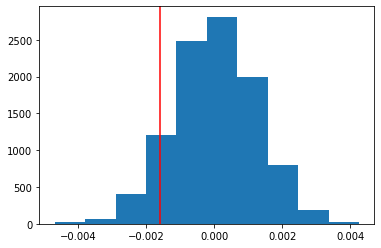

In [79]:
# p_diffs = np.array(p_diffs)
obs_diff = p_treatment_converted - p_control_converted

plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [80]:
p_val = (p_diffs > obs_diff).mean()
p_val

0.9068

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Results:** In part **j**, I calculated the proportion of p_diffs that were greater than the actual difference, which in scientific studies is known as the p-value, as 0.907. The p-value is the probability of observing the statistic if the null hypothesis is true. Since, in this case the probability is well over 0.05, we would fail to reject the null and suggest that the company keep the old page. Given that the p-value is so high, it seems unlikely that continuing the A/B test any longer would provide different results.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
# Use the stats.proportions_ztest to compute the pvalue
# Since the alternative hypothesis is that p_new will be larger than p_old,  
# the arrays have the new values first I used alternative as larger
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
z_score, p_val = sm.stats.proportions_ztest(count, nobs, alternative='larger')
z_score, p_val

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Results:** Running the stats.proportions.test resulted in a p-value of roughly 0.905, which is slightly higher than the p-value from my other calculation. Both calculated p-values are much greater than alpha of 0.05 so we would fail to reject the null and recommend that the company retain the old page. 

I was not as familiar with the z-score. I did a bit of searching and found a helpful article at [ESRI](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm) that I found easy to understand. ESRI supplies GIS mapping and spatial analytics software, so they provide easy to understand documentation to help their customers understand the analytics and statistics you might see in their products. While the application is different, the basic description of the p-value and z-score were still accurate and useful to my learning.

This article specifically mentioned how to evaluate both the p-value and the z-score when you have an alpha of 5%. It described the z-score as a measure of the standard deviation. So, my results of -1.31 for a z-score indicated that the result were within 1.31 times the standard deviation, which, like the p-value results, would not allow you to reject the null hypothesis. The article included a table for typical alpha values and for 5%, you would want the z-score to fall outside of the -1.96 to 1.96 range in order to reject the null. My result did not fail outside of that range. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Response:** Since we are looking to determine if there is a direct relationship between the landing page and whether an individual converts, I can use a linear regression model. We can use the group to test how well we can predict the conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Add intercept and ab_page columns to df2 and verify the ab_page column is 1 for treatment or 0 for control
df2['intercept'] = 1
df2['ab_page'] = (df2['group'] == 'treatment').astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
# Import the correct package for modeling
import statsmodels.api as sm;

# Use the OLS (Ordinary Line Regression) to see how well our data fit and whether we can predict conversion
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']]) 
results = lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
# Display the summary of the linear regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Mon, 25 Nov 2019   Prob (F-statistic):              0.190
Time:                        17:20:13   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Response** The p-value associated with ab_page is 0.19, but we used a different null and alternative hypothesis with this linear model. In this case the 𝐻_0: coef of ab_page = 0 and H_1: coef of ab_page is not equal to 0. This p-value is greater than 0.05 and indicates we should fail to reject the null hypothesis that the coef of ab_page is 0. Another indicator to use from the summary is the R-squared value, which is 0. This also indicates that the model is not a good fit and that we should not reject the null. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Response** It is possible that more than one factor influence behavior, especially human behavior. A good way to test to see if more than one factor influences is do multiple linear regressions with additional variables and evaluate the results. You must be mindfult that there can be problems with multiple linear regression, such as correlated errors or multicollinearity (when more than one independent variable are correlated to each other). There are ways to avoid or check for these errors. For example, if you suspect multicollinearity, you can plotting the independent variables or calculate the VIF (Variance Inflation Factor) for each variable and see if any are greater than 10. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [34]:
# Determine what countries are in the dataset
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [35]:
### Create the necessary dummy variables for the countries

# Use get_dummies to create to new dummy columns
# I could have created only two dummy columns, but wanted to try to run the linear model with each
# pair to see which was the easiest to interpret the results
df_new[['ca','uk','us']] = pd.get_dummies(df_new['country'], dtype=int)

# Verify the dummy columns; I used tail because it included rows from each country
df_new.tail() 

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,1,0,0
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
### Fit Your Linear Model And Obtain the Results
# Use the OLS (Ordinary Least Squared) to see how well our data fit and whether we can predict conversion
# Left out CA as the baseline as that was the cleanest after trying each pair
lm = sm.OLS(df_new['converted'], df_new[['intercept','ab_page', 'us', 'uk']]) 
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Mon, 25 Nov 2019   Prob (F-statistic):              0.178
Time:                        17:20:14   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1161      0.003     42.036      0.000       0.111       0.122
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
us             0.0042      0.003      1.514      0.130      -0.001       0.010
uk             0.0053      0.003      1.784      0.074      -0.001       0.011
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Evaluation of influence of country** The multiple linear regression results above measured whether the interaction between country and page significantly effects conversion. In this case the null hypothesis is that the country and page do not affect the conversion. The results with p-values all above 0.05 and R-squared of 0 would indicate that we should not reject the null hypothesis and that we would not make different recommendations for one country versus another. 

<a id='conclusions'></a>
## Conclusions

In this project, I used a number of different methods from simple probabilty through multiple linear regression to evaluate the A/B test run by an e-commerce company. Each of the methods and tests resulted in the same conclusion that I would recommend that the company keep the old page and end the experiment. 